# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.metrics import roc_auc_score
from sklearn import metrics, linear_model
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
from random import randint

In [2]:
variable_descriptions = pd.read_csv("/Users/sangbin/Desktop/Coursework_files/dataverse_files/variable-descriptions.csv")
variable_descriptions

,Name,Description
0,Year,1987-2008
1,Month,12-Jan
2,DayofMonth,31-Jan
3,DayOfWeek,1 (Monday) - 7 (Sunday)
4,DepTime,"actual departure time (local, hhmm)"
5,CRSDepTime,"scheduled departure time (local, hhmm)"
6,ArrTime,"actual arrival time (local, hhmm)"
7,CRSArrTime,"scheduled arrival time (local, hhmm)"
8,UniqueCarrier,unique carrier code
9,FlightNum,flight number


In [3]:
# Read all the dataset we will be using.

airports = pd.read_csv("/Users/sangbin/Desktop/Coursework_files/dataverse_files/airports.csv")
carriers = pd.read_csv("/Users/sangbin/Desktop/Coursework_files/dataverse_files/carriers.csv")
planes = pd.read_csv("/Users/sangbin/Desktop/Coursework_files/dataverse_files/plane-data.csv")


df_03 = pd.read_csv(
    "/Users/sangbin/Desktop/Coursework_files/dataverse_files/2003.csv.bz2",
    compression='bz2',
    low_memory=False)

df_04 = pd.read_csv(
    "/Users/sangbin/Desktop/Coursework_files/dataverse_files/2004.csv.bz2",
    compression='bz2',
    low_memory=False)

df_05 = pd.read_csv(
    "/Users/sangbin/Desktop/Coursework_files/dataverse_files/2005.csv.bz2",
    compression='bz2',
    low_memory=False)

# Concatenate all the flight detail dataset into one dataset

df = pd.concat([df_03, df_04, df_05])

In [4]:
# Save memory by manually downcasting the columns into the smallest type that can handle its values

for column in df:
    if df[column].dtype == "float64":
        df[column] = pd.to_numeric(df[column], downcast="float")
    if df[column].dtype == "int64":
        df[column] = pd.to_numeric(df[column], downcast="integer")

df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20758406 entries, 0 to 7140595
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int16  
 1   Month              int8   
 2   DayofMonth         int8   
 3   DayOfWeek          int8   
 4   DepTime            float32
 5   CRSDepTime         int16  
 6   ArrTime            float32
 7   CRSArrTime         int16  
 8   UniqueCarrier      object 
 9   FlightNum          int16  
 10  TailNum            object 
 11  ActualElapsedTime  float32
 12  CRSElapsedTime     float32
 13  AirTime            float32
 14  ArrDelay           float32
 15  DepDelay           float32
 16  Origin             object 
 17  Dest               object 
 18  Distance           int16  
 19  TaxiIn             int16  
 20  TaxiOut            int16  
 21  Cancelled          int8   
 22  CancellationCode   object 
 23  Diverted           int8   
 24  CarrierDelay       float32
 25  WeatherDelay     

# Data Exploration

In [5]:
# Create date column by concatenating year,month and day

df['Date'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.DayofMonth),format = '%Y%m%d')
df['Date'].head()

0   2003-01-29
1   2003-01-30
2   2003-01-31
3   2003-01-01
4   2003-01-02
Name: Date, dtype: datetime64[ns]

In [6]:
# make a copy of df just in case we need the original data

df_copy = df.copy()

In [7]:
# We are able to identify that if the flight is cancelled or diverted, there is no delay occurred.
# A flight diversion is when an aircraft is unable to arrive at its final destination.
# Hence we will filter out the cancelled and diverted flights for questions 1 to 4 just for now.
# Drop cancellation code

df_copy = df_copy[(df_copy['Cancelled'] == 0)]
df_copy = df_copy[(df_copy['Diverted'] == 0)]
df_copy = df_copy.drop("CancellationCode",1)

/var/folders/5y/7dw_ny511gddhzy9yhty7ln40000gn/T/ipykernel_4964/1815415204.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_copy = df_copy.drop("CancellationCode",1)


In [8]:
# Make new columns to indicate delay of arrival and departure.
# 0 = on time , 1 = delayed

df_copy["DelayedArr"] = 0
df_copy["DelayedDep"] = 0

# According to Bureau of Transportation statistics, a flight is counted as "on time" if the flight
# operated less than 15 minutes later than the scheduled time shown in the carriers' Computerized Reservations Systems (CRS).
# Thus, On-time means a flight that arrives less than 15 mintues after its published arrival time.

df_copy.loc[df_copy["ArrDelay"] > 15, "DelayedArr"] = 1
df_copy.loc[df_copy["DepDelay"] > 15, "DelayedDep"] = 1

In [9]:
# Missing data (or Not a Number data) tells us that these features are not the cause of it. 
# Hence convert NaN values into 0

df_copy['CarrierDelay'] = df_copy['CarrierDelay'].fillna(0)
df_copy['WeatherDelay'] = df_copy['WeatherDelay'].fillna(0)
df_copy['NASDelay'] = df_copy['NASDelay'].fillna(0)
df_copy['SecurityDelay'] = df_copy['SecurityDelay'].fillna(0)
df_copy['LateAircraftDelay'] = df_copy['LateAircraftDelay'].fillna(0)

In [10]:
# Count the number of delayed arrivals

df_copy[df_copy.DelayedArr == 1].count()

Year                 3761176
Month                3761176
DayofMonth           3761176
DayOfWeek            3761176
DepTime              3761176
CRSDepTime           3761176
ArrTime              3761176
CRSArrTime           3761176
UniqueCarrier        3761176
FlightNum            3761176
TailNum              3761162
ActualElapsedTime    3761176
CRSElapsedTime       3761176
AirTime              3761176
ArrDelay             3761176
DepDelay             3761176
Origin               3761176
Dest                 3761176
Distance             3761176
TaxiIn               3761176
TaxiOut              3761176
Cancelled            3761176
Diverted             3761176
CarrierDelay         3761176
WeatherDelay         3761176
NASDelay             3761176
SecurityDelay        3761176
LateAircraftDelay    3761176
Date                 3761176
DelayedArr           3761176
DelayedDep           3761176
dtype: int64

In [11]:
# Count the number of On-time arrivals

df_copy[df_copy.DelayedArr == 0 ].count()

Year                 16595081
Month                16595081
DayofMonth           16595081
DayOfWeek            16595081
DepTime              16595081
CRSDepTime           16595081
ArrTime              16595081
CRSArrTime           16595081
UniqueCarrier        16595081
FlightNum            16595081
TailNum              16595037
ActualElapsedTime    16595080
CRSElapsedTime       16595081
AirTime              16595081
ArrDelay             16595080
DepDelay             16595081
Origin               16595081
Dest                 16595081
Distance             16595081
TaxiIn               16595081
TaxiOut              16595081
Cancelled            16595081
Diverted             16595081
CarrierDelay         16595081
WeatherDelay         16595081
NASDelay             16595081
SecurityDelay        16595081
LateAircraftDelay    16595081
Date                 16595081
DelayedArr           16595081
DelayedDep           16595081
dtype: int64

In [12]:
# we can identify that there are no missing values in the dataframe except tailnum

df_copy = df_copy[df_copy["ArrDelay"].notna()]
df_copy.isnull().sum()

Year                  0
Month                 0
DayofMonth            0
DayOfWeek             0
DepTime               0
CRSDepTime            0
ArrTime               0
CRSArrTime            0
UniqueCarrier         0
FlightNum             0
TailNum              58
ActualElapsedTime     0
CRSElapsedTime        0
AirTime               0
ArrDelay              0
DepDelay              0
Origin                0
Dest                  0
Distance              0
TaxiIn                0
TaxiOut               0
Cancelled             0
Diverted              0
CarrierDelay          0
WeatherDelay          0
NASDelay              0
SecurityDelay         0
LateAircraftDelay     0
Date                  0
DelayedArr            0
DelayedDep            0
dtype: int64

In [13]:
# Use a convert_time function to convert concatenated hours and minutes into "hh:mm" format and 24-hour notation

def convert_time(x):
    try:
        if x != 0 or x != np.NAN:
            if str(int(x))[:-2].zfill(2) == '24':
                hour = '00'
            elif str(int(x))[:-2].zfill(2) == '25':
                hour = '01'
            elif str(int(x))[:-2].zfill(2) == '26':
                hour = '02'
            elif str(int(x))[:-2].zfill(2) == '27':
                hour = '03'
            elif str(int(x))[:-2].zfill(2) == '28':
                hour = '04'
            elif str(int(x))[:-2].zfill(2) == '29':
                hour = '05'
            else:
                hour = str(int(x))[:-2].zfill(2)

            minutes = str(int(x))[-2:].zfill(2)
            time_format = f"{hour}:{minutes}"
        return time_format
    except Exception as e:
        pass

In [14]:
# convert concatenated hours and minutes

df_copy['DepTime'] = df_copy['DepTime'].apply(convert_time)
df_copy['CRSDepTime'] = df_copy['CRSDepTime'].apply(convert_time)
df_copy['ArrTime'] = df_copy['ArrTime'].apply(convert_time)
df_copy['CRSArrTime'] = df_copy['CRSArrTime'].apply(convert_time)

In [15]:
# Extract the hour

df_copy['DepHour'] = df_copy['DepTime'].apply(lambda x: x[:2])
df_copy['ArrHour'] = df_copy['ArrTime'].apply(lambda x: x[:2])
df_copy['CRSDepHour'] = df_copy["CRSDepTime"].apply(lambda x: x[:2])
df_copy['CRSArrHour'] = df_copy["CRSArrTime"].apply(lambda x: x[:2])

In [16]:
# Lets deepdive into delays.

df_copy_WithoutOutlier = df_copy.copy()

In [17]:
# The minimum and max value of DepDelay and ArrDelay seems weird.
# This kind of extreme delays could cause a bias to the research.

df_copy_WithoutOutlier.groupby('Month')[['DepDelay', 'ArrDelay']].describe()

DepDelay                                                        \
           count       mean        std     min  25%  50%   75%     max   
Month                                                                    
1      1676313.0   7.840046  30.082169 -1410.0 -4.0  0.0   6.0  1930.0   
2      1557632.0   7.184305  27.858242 -1160.0 -4.0  0.0   5.0  1676.0   
3      1748262.0   6.563198  28.086657 -1198.0 -4.0  0.0   5.0  1517.0   
4      1684373.0   4.231573  24.246614 -1178.0 -5.0 -1.0   2.0  1519.0   
5      1719206.0   5.916639  27.607996 -1197.0 -4.0  0.0   3.0  1458.0   
6      1707437.0   9.337245  31.948387 -1185.0 -3.0  0.0   8.0  1497.0   
7      1764088.0  10.826310  35.065262 -1194.0 -3.0  0.0   9.0  1732.0   
8      1773723.0   8.714051  32.098106 -1199.0 -4.0  0.0   7.0  1532.0   
9      1647266.0   3.913630  23.850122 -1141.0 -5.0 -1.0   1.0  1637.0   
10     1730550.0   5.045703  24.777412  -941.0 -4.0 -1.0   3.0  1450.0   
11     1655630.0   6.862856  27.915237 -1184.0 -4.0  0.0   5.0  1659.0   
12     1691776.0  10.956065  32.673264 -1185.0 -3.0  0.0  11.0  1817.0   

        ArrDelay                                                         
           count       mean        std     min   25%  50%   75%     max  
Month                                                                    
1      1676313.0   6.766408  34.715683  -950.0 -10.0 -1.0  11.0  1925.0  
2      1557632.0   6.049751  32.052864  -770.0 -10.0 -1.0  11.0  1667.0  
3      1748262.0   4.736025  31.711670  -692.0 -10.0 -2.0   9.0  1502.0  
4      1684373.0   1.720231  27.116390  -939.0 -11.0 -4.0   6.0  1612.0  
5      1719206.0   4.221227  31.462351  -664.0 -10.0 -3.0   7.0  1448.0  
6      1707437.0   8.494094  35.423573  -853.0  -8.0 -1.0  12.0  1491.0  
7      1764088.0  10.015094  38.848606 -1035.0  -8.0 -1.0  13.0  1735.0  
8      1773723.0   7.680830  35.227428  -303.0  -9.0 -1.0  11.0  1517.0  
9      1647266.0   1.545170  27.170357  -687.0 -11.0 -4.0   5.0  1631.0  
10     1730550.0   3.182621  27.620806  -719.0 -10.0 -3.0   7.0  1465.0  
11     1655630.0   5.281877  31.342981  -978.0 -10.0 -2.0  10.0  1639.0  
12     1691776.0   9.950251  35.878368 -1302.0  -8.0  0.0  15.0  1864.0

In [18]:
# As outliers give impact to average of ArrDelay and DepDelay, remove them.
# Number of rows before removing outliers = 20356256 rows

df_copy_WithoutOutlier.shape

(20356256, 35)

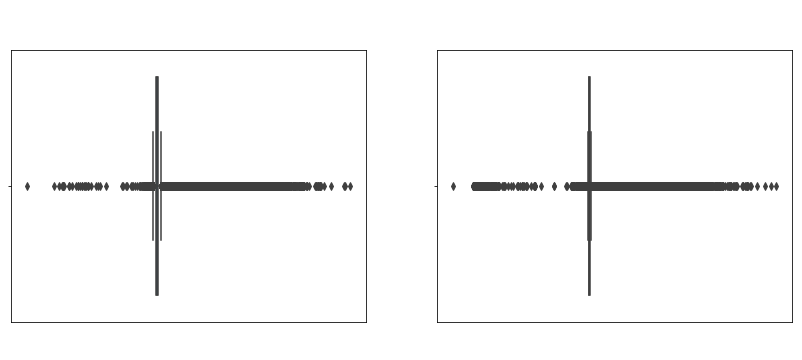

In [19]:
figure, (test1, test2) = plt.subplots(ncols = 2)
figure.set_size_inches(14,5)

# Main Title
figure.suptitle('Boxplot Before IQR based filtering',x=0.52, y=1,fontsize = 16,fontweight ="bold", color = "white")

# # Arrival delay boxplot
# Identify the outlier of ArrDelay

sns.boxplot(data=df_copy_WithoutOutlier, x=df_copy_WithoutOutlier["ArrDelay"], ax = test1)
         
# title, lables & legend
test1.set_title("ArrDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
test1.set_xlabel('ArrDelay', fontsize = 10, weight = "bold",color = "white")
test1.tick_params(axis='x', colors='white')

#-------------------------------------------------------------------------------------
# Departure delay boxplot
# Identify the outlier of DepDelay

sns.boxplot(data=df_copy_WithoutOutlier, x=df_copy_WithoutOutlier["DepDelay"], ax = test2)

# title, lables & legend

test2.set_title("DepDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
test2.set_xlabel('DepDelay', fontsize = 10, weight = "bold",color = "white")
test2.tick_params(axis='x', colors='white')

In [20]:
# identify first, third quartile and interquartile range to identify the lower and upper whisker of arrival delay
Q1 = df_copy_WithoutOutlier["ArrDelay"].quantile(0.25)
Q3 = df_copy_WithoutOutlier["ArrDelay"].quantile(0.75)
IQR = Q3 - Q1
Lower_Whisker = Q1 - 1.5 * IQR
Upper_Whisker = Q3 + 1.5 * IQR
print("1st Quartile =",Q1)
print("3rd Quartile =",Q3)
print("Interquartile Range=",IQR)
print("Lower Whisker =",Lower_Whisker,"Upper Whisker =", Upper_Whisker)

1st Quartile = -10.0
3rd Quartile = 10.0
Interquartile Range= 20.0
Lower Whisker = -40.0 Upper Whisker = 40.0


In [21]:
# identify first, third quartile and interquartile range to identify the lower and upper whisker of departure delay
Q1 = df_copy_WithoutOutlier["DepDelay"].quantile(0.25)
Q3 = df_copy_WithoutOutlier["DepDelay"].quantile(0.75)
IQR = Q3 - Q1
Lower_Whisker = Q1 - 1.5 * IQR
Upper_Whisker = Q3 + 1.5 * IQR
print("1st Quartile =",Q1)
print("3rd Quartile =",Q3)
print("Interquartile Range=",IQR)
print("Lower Whisker =",Lower_Whisker,"Upper Whisker =", Upper_Whisker)

1st Quartile = -4.0
3rd Quartile = 5.0
Interquartile Range= 9.0
Lower Whisker = -17.5 Upper Whisker = 18.5


In [22]:
# Outliers will be any points below Lower_Whisker or above Upper_Whisker hence sort them out.

df_copy_WithoutOutlier = df_copy_WithoutOutlier[(df_copy_WithoutOutlier["ArrDelay"] < Upper_Whisker) & 
                                  (df_copy_WithoutOutlier["ArrDelay"] > Lower_Whisker) & 
                                  (df_copy_WithoutOutlier["DepDelay"] < Upper_Whisker) & 
                                  (df_copy_WithoutOutlier["DepDelay"] > Lower_Whisker)]

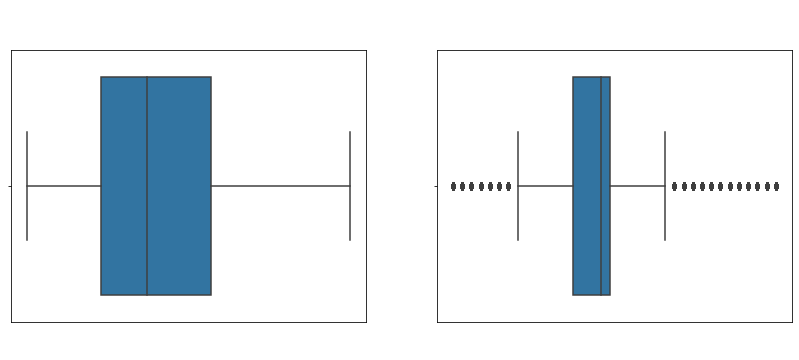

In [23]:
figure, (test1_1, test2_1) = plt.subplots(ncols = 2)
figure.set_size_inches(14,5)

# Main Title
figure.suptitle('Boxplot After IQR based filtering',x=0.52, y=1,fontsize = 16,fontweight ="bold", color = "white")

# Left Plot
# Identify the outlier of ArrDelay

sns.boxplot(data=df_copy_WithoutOutlier, x=df_copy_WithoutOutlier["ArrDelay"], ax = test1_1)
         
# title, lables & legend
test1_1.set_title("ArrDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
test1_1.set_xlabel('ArrDelay', fontsize = 10, weight = "bold",color = "white")
test1_1.tick_params(axis='x', colors='white')

#-------------------------------------------------------------------------------------
# Right Plot
# Identify the outlier of DepDelay

sns.boxplot(data=df_copy_WithoutOutlier, x=df_copy_WithoutOutlier["DepDelay"], ax = test2_1)

# title, lables & legend

test2_1.set_title("DepDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
test2_1.set_xlabel('DepDelay', fontsize = 10, weight = "bold",color = "white")
test2_1.tick_params(axis='x', colors='white')

In [24]:
# After the filtering
df_copy_WithoutOutlier.shape

(14981638, 35)

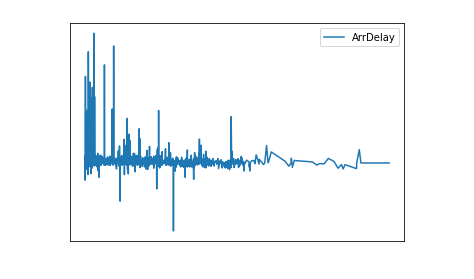

In [25]:
# Grouped based on distance and showed average arrival delay.

distance_delay = df_copy.groupby('Distance').agg({'ArrDelay': np.mean}).reset_index()

distance_delay.plot(x='Distance', y='ArrDelay')

plt.title("Distribution of arrival delay based on distance (W Outlier)",
          fontsize=14,
          weight="bold",
          color="white")
plt.ylabel('Average Delay (min)', fontsize=10, weight="bold", color="white")
plt.xlabel('Distance', fontsize=10, weight="bold", color="white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.show()

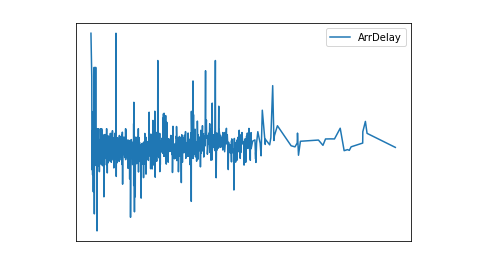

In [26]:
# Grouped based on distance and showed average arrival delay without outliers.

distance_delay = df_copy_WithoutOutlier.groupby('Distance').agg({'ArrDelay' : np.mean}).reset_index()

distance_delay.plot(x='Distance', y='ArrDelay')


plt.title("Distribution of arrival delay based on distance(W/O Outlier)", fontsize = 14, weight = "bold", color = "white")
plt.ylabel('Average Delay (min)', fontsize = 10, weight = "bold", color = "white")
plt.xlabel('Distance', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.show()

We can observe that shorter distanced flights seem to have more fluctuation on delays compared to long distance flights

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


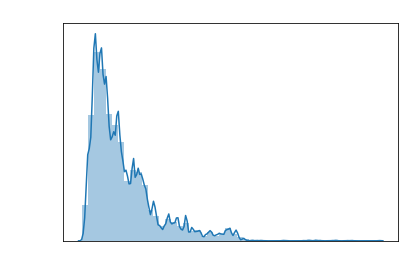

In [27]:
# Frequency of the flight over distance
sns.distplot(df_copy_WithoutOutlier['Distance'])

plt.title("Frequency of the flight over distance", fontsize = 14, weight = "bold", color = "white")
plt.ylabel('Frequency of the flight', fontsize = 10, weight = "bold", color = "white")
plt.xlabel('Distance', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.show()

We can observe that there are more of shorter distanced flights compared to long distance flights

In [28]:
# show all columns

pd.options.display.max_columns = None

# 1) When is the best time of day, day of the week, and time of year to fly to minimize delays?

In [29]:
# Deep dive into Delayed arrival flights

Delayed_flights = df_copy[df_copy["DelayedArr"] == 1]

In [30]:
# Number of arrival delayed flights = 3761176
Delayed_flights.shape

(3761176, 35)

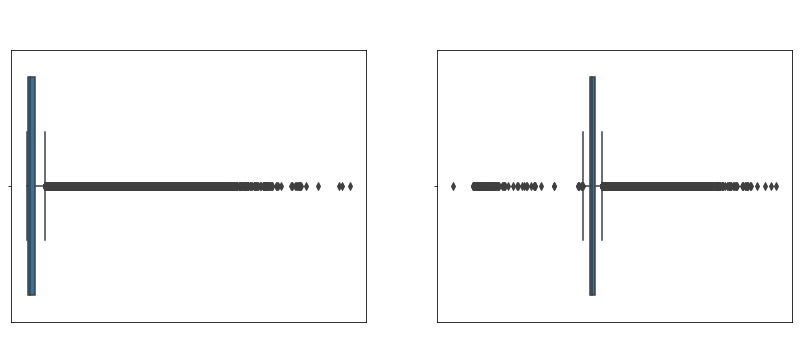

In [31]:
figure, (bp1, bp2) = plt.subplots(ncols = 2)
figure.set_size_inches(14,5)

# Main Title
figure.suptitle('A) Boxplot Before IQR based filtering',x=0.52, y=1,fontsize = 16,fontweight ="bold", color = "white")

# Arrival delay boxplot
# Identify the outlier of ArrDelay

sns.boxplot(data=Delayed_flights, x=Delayed_flights["ArrDelay"], ax = bp1)
         
# title, lables & legend
bp1.set_title("1) ArrDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
bp1.set_xlabel('ArrDelay', fontsize = 10, weight = "bold",color = "white")
bp1.tick_params(axis='x', colors='white')

#-------------------------------------------------------------------------------------
# Departure delay boxplot
# Identify the outlier of DepDelay

sns.boxplot(data=Delayed_flights,x=Delayed_flights["DepDelay"], ax = bp2)                                                                
# title, lables & legend
bp2.set_title("2) DepDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
bp2.set_xlabel('DepDelay', fontsize = 10, weight = "bold",color = "white")
bp2.tick_params(axis='x', colors='white')

#figure.savefig("Question1(Boxplot Before IQR based filtering).png")

In [32]:
# identify first, third quartile and interquartile range to identify the lower and upper whisker
Q1 = Delayed_flights["ArrDelay"].quantile(0.25)
Q3 = Delayed_flights["ArrDelay"].quantile(0.75)
IQR = Q3 - Q1
Lower_Whisker = Q1 - 1.5 * IQR
Upper_Whisker = Q3 + 1.5 * IQR
print("1st Quartile =",Q1)
print("3rd Quartile =",Q3)
print("Interquartile Range=",IQR)
print("Lower Whisker =",Lower_Whisker,"Upper Whisker =", Upper_Whisker)

1st Quartile = 23.0
3rd Quartile = 63.0
Interquartile Range= 40.0
Lower Whisker = -37.0 Upper Whisker = 123.0


In [33]:
Q1 = Delayed_flights["DepDelay"].quantile(0.25)
Q3 = Delayed_flights["DepDelay"].quantile(0.75)
IQR = Q3 - Q1
Lower_Whisker = Q1 - 1.5 * IQR
Upper_Whisker = Q3 + 1.5 * IQR
print("1st Quartile =",Q1)
print("3rd Quartile =",Q3)
print("Interquartile Range =",IQR)
print("Lower Whisker =",Lower_Whisker,"Upper Whisker =", Upper_Whisker)

1st Quartile = 10.0
3rd Quartile = 58.0
Interquartile Range = 48.0
Lower Whisker = -62.0 Upper Whisker = 130.0


In [34]:
# Outliers will be any points below Lower_Whisker or 
# above Upper_Whisker hence sort them out from arrival delayed flights.

Delayed_flights = Delayed_flights[(Delayed_flights["ArrDelay"] < Upper_Whisker) & 
                                  (Delayed_flights["ArrDelay"] > Lower_Whisker) & 
                                  (Delayed_flights["DepDelay"] < Upper_Whisker) & 
                                  (Delayed_flights["DepDelay"] > Lower_Whisker)]

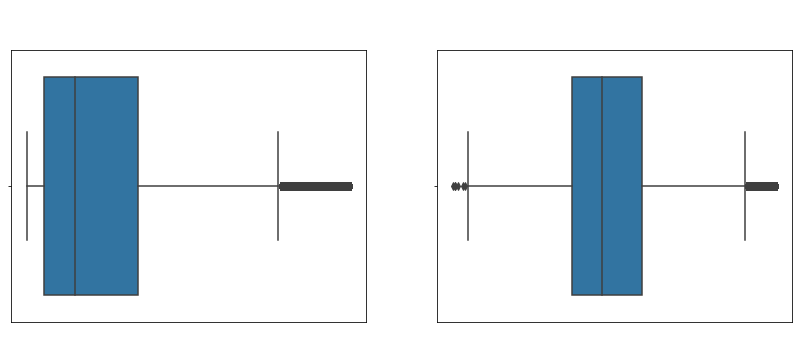

In [35]:
figure, (bp3, bp4) = plt.subplots(ncols = 2)
figure.set_size_inches(14,5)

# Main Title
figure.suptitle('B) Boxplot After IQR based filtering',x=0.52, y=1,fontsize = 16,fontweight ="bold", color = "white")

sns.boxplot(data=Delayed_flights, x=Delayed_flights["ArrDelay"], ax = bp3)
         
# title, lables & legend
bp3.set_title("1) ArrDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
bp3.set_xlabel('ArrDelay', fontsize = 10, weight = "bold",color = "white")
bp3.tick_params(axis='x', colors='white')

#-------------------------------------------------------------------------------------

sns.boxplot(data=Delayed_flights,x=Delayed_flights["DepDelay"], ax = bp4)                                                                
# title, lables & legend
bp4.set_title("2) DepDelay Boxplot", fontsize = 14, weight = "bold",color = "white")
bp4.set_xlabel('DepDelay', fontsize = 10, weight = "bold",color = "white")
bp4.tick_params(axis='x', colors='white')

In [36]:
# 272736 rows have been removed
Delayed_flights.shape

(3488440, 35)

In [37]:
# Details of flights in each departure hour

Delayed_flights.groupby('DepHour')[['DepDelay', 'ArrDelay']].describe()

DepDelay                                                        \
            count       mean        std   min   25%   50%    75%    max   
DepHour                                                                   
00        16458.0  55.804836  36.339619 -18.0  26.0  51.0  85.00  129.0   
01         4789.0  57.449154  37.461914 -24.0  26.0  56.0  88.00  129.0   
02         1144.0  60.163460  36.374603 -13.0  31.0  59.0  90.00  129.0   
03          231.0  61.766235  33.197262 -12.0  33.5  56.0  87.50  128.0   
04          106.0  25.160378  45.659637 -15.0  -6.0  -2.0  58.75  123.0   
05        10656.0   0.795983   9.929603 -30.0  -5.0  -2.0   0.00  121.0   
06        76230.0   7.208645  15.428082 -55.0  -3.0   0.0  14.00  115.0   
07       120386.0  16.484491  23.415197 -54.0  -1.0   8.0  29.00  128.0   
08       152778.0  20.685949  27.049101 -60.0   0.0  12.0  33.00  129.0   
09       169452.0  24.194721  27.244251 -36.0   1.0  18.0  38.00  129.0   
10       169716.0  27.774529  28.286247 -58.0   5.0  22.0  42.00  129.0   
11       183552.0  28.487333  27.734516 -52.0   6.0  23.0  43.00  129.0   
12       192508.0  29.196787  28.159828 -34.0   7.0  24.0  44.00  129.0   
13       221738.0  28.238470  27.556160 -41.0   6.0  24.0  42.00  129.0   
14       218700.0  31.272602  28.601404 -44.0   9.0  26.0  47.00  129.0   
15       253391.0  30.591339  28.461027 -61.0   9.0  25.0  45.00  129.0   
16       253906.0  33.560558  28.724237 -41.0  12.0  29.0  50.00  129.0   
17       294640.0  32.270725  29.035143 -35.0  10.0  27.0  47.00  129.0   
18       296435.0  36.923424  29.541662 -40.0  15.0  32.0  55.00  129.0   
19       285061.0  39.594013  30.715008 -45.0  17.0  34.0  58.00  129.0   
20       232394.0  44.762836  31.174919 -35.0  22.0  40.0  65.00  129.0   
21       183685.0  47.087540  31.197323 -22.0  24.0  41.0  67.00  129.0   
22       106715.0  53.057320  33.025623 -52.0  27.0  49.0  78.00  129.0   
23        43769.0  57.425598  34.712448 -39.0  30.0  54.0  84.00  129.0   

         ArrDelay                                                       
            count       mean        std   min   25%   50%   75%    max  
DepHour                                                                 
00        16458.0  55.158401  31.983154  16.0  26.0  47.0  81.0  129.0  
01         4789.0  57.040302  32.099304  16.0  27.0  52.0  83.0  129.0  
02         1144.0  58.995628  32.558342  16.0  29.0  53.5  85.0  129.0  
03          231.0  58.562771  30.640322  16.0  33.5  52.0  84.0  128.0  
04          106.0  47.141510  34.766285  16.0  19.0  28.0  81.0  127.0  
05        10656.0  27.108295  14.303256  16.0  18.0  22.0  30.0  129.0  
06        76230.0  28.812330  15.309487  16.0  19.0  24.0  33.0  129.0  
07       120386.0  33.316433  19.364777  16.0  20.0  26.0  40.0  129.0  
08       152778.0  35.704792  22.137535  16.0  20.0  28.0  43.0  129.0  
09       169452.0  37.001404  22.516199  16.0  21.0  29.0  45.0  129.0  
10       169716.0  38.175648  23.496590  16.0  21.0  30.0  47.0  129.0  
11       183552.0  37.972046  23.249905  16.0  21.0  30.0  47.0  129.0  
12       192508.0  38.964031  23.935102  16.0  21.0  30.0  49.0  129.0  
13       221738.0  39.030476  23.801298  16.0  21.0  31.0  49.0  129.0  
14       218700.0  41.058167  24.908148  16.0  22.0  32.0  53.0  129.0  
15       253391.0  41.250561  25.139225  16.0  22.0  33.0  53.0  129.0  
16       253906.0  42.773891  25.807209  16.0  23.0  34.0  55.0  129.0  
17       294640.0  42.502541  25.834110  16.0  23.0  34.0  55.0  129.0  
18       296435.0  45.328072  26.763678  16.0  24.0  37.0  60.0  129.0  
19       285061.0  46.113186  27.284803  16.0  24.0  37.0  61.0  129.0  
20       232394.0  48.436779  28.162998  16.0  25.0  40.0  66.0  129.0  
21       183685.0  49.123596  28.280666  16.0  26.0  41.0  67.0  129.0  
22       106715.0  53.795605  30.080732  16.0  27.0  47.0  76.0  129.0  
23        43769.0  57.247551  31.323950  16.0  29.0  51.0  81.0  129.0

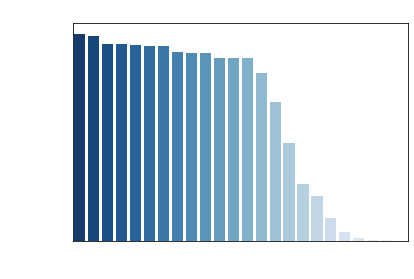

In [38]:
# Plot Total number of flights in descending order

# get the order
order = df_copy['DepHour'].value_counts().index

sns.countplot(data = df_copy, x = 'DepHour', order = order, palette = 'Blues_r')

# axes labels and title

plt.title("C-1) Total number of flights per hour", fontsize = 14, weight = "bold", color = "white")
plt.xlabel('Actual Departure Hour', fontsize = 10, weight = "bold", color = "white")
plt.ylabel('Number of flights', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show()

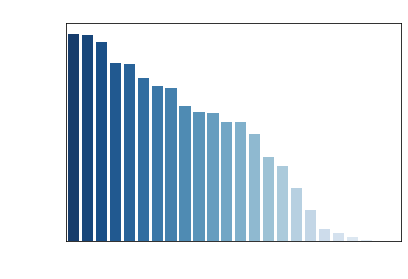

In [39]:
# Plot Total number of delayed flights in descending order

# get the order
order = Delayed_flights['DepHour'].value_counts().index

sns.countplot(data = Delayed_flights, x = 'DepHour', order = order, palette = 'Blues_r')

# axes labels and title

plt.title("C-2) Number of delayed flights per hour", fontsize = 14, weight = "bold", color = "white")
plt.xlabel('Actual Departure Hour', fontsize = 10, weight = "bold", color = "white")
plt.ylabel('Number of delayed flights', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.show()


We can identify that number of flights differ by hour. 

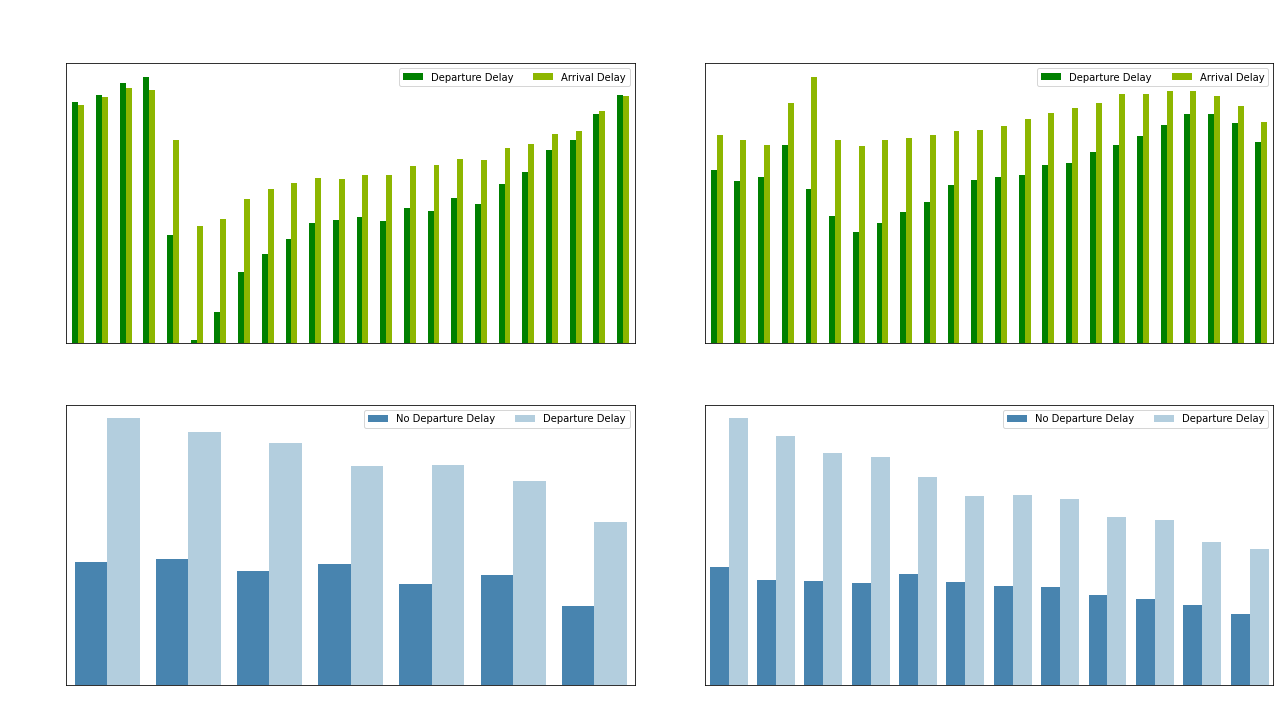

In [40]:
# Plot graphs that can aid choosing best time to minimize delays

figure, ((ax1, ax2,),(ax3,ax4)) = plt.subplots(ncols = 2, nrows = 2)
figure.set_size_inches(18,10)

# Main Title
figure.suptitle('D) Best Time to Minimize Delayes',x=0.52, y=1,fontsize = 18,fontweight ="bold", color = "white")

# Identify the best time of Departure hour to book a flight
colors = ['#008000', '#8DB600']

# Top Left Plot
Delayed_flights.groupby('DepHour')[['DepDelay','ArrDelay']].mean().plot.bar(color=colors, ax = ax1)

# title, lables & legend
ax1.set_title("1) Distribution of delay over the hours day", fontsize = 14, weight = "bold",color = "white")
ax1.set_xlabel('Actual Departure Hour', fontsize = 10, weight = "bold",color = "white")
ax1.set_ylabel('Average Delay (min)', fontsize = 10, weight = "bold",color = "white")
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')

ax1.legend(labels = ['Departure Delay', 'Arrival Delay'], ncol = 2)

#-------------------------------------------------------------------------------------
# Top Right Plot
Delayed_flights.groupby('CRSDepHour')[['DepDelay','ArrDelay']].mean().plot.bar(color=colors, ax= ax2)
                                                                
# title, lables & legend
ax2.set_title("2) Distribution of delay over the hours day", fontsize = 14, weight = "bold",color = "white")
ax2.set_xlabel('Scheduled Departure Hour', fontsize = 10, weight = "bold",color = "white")
ax2.set_ylabel('Average Delay (min)', fontsize = 10, weight = "bold",color = "white")
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')

ax2.legend(labels = ['Departure Delay', 'Arrival Delay'], ncol = 2)

#-------------------------------------------------------------------------------------
# Identify the best day of week to book a flight

# get the order
order = Delayed_flights.Date.dt.day_name().value_counts().index

# Bottom Left Plot
sns.countplot(data = Delayed_flights, x = Delayed_flights.Date.dt.day_name(), order = order, palette = 'Blues_r',hue = "DelayedDep", ax= ax3)

# axes labels and title
ax3.set_title('3) Number of Arrival Delay by Day', fontsize = 14, weight = "bold",color = "white")
ax3.set_xlabel('Day', fontsize = 10, weight = "bold",color = "white")
ax3.set_ylabel('Arrival Delay Count', fontsize = 10, weight = "bold",color = "white")
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')

ax3.legend(labels = ['No Departure Delay', 'Departure Delay'], ncol = 2)
#------------------------------------------------------------------------------------
# Identify the best day of month to book a flight


# get the order
order = Delayed_flights.Date.dt.month_name().value_counts().index

# Bottom Right Plot
sns.countplot(data=Delayed_flights, x=Delayed_flights.Date.dt.month_name(), order=order, palette='Blues_r',hue = "DelayedDep", ax= ax4)

# axes labels and title
ax4.set_title('4) Number of Arrival Delay by Month', fontsize = 14, weight = "bold",color = "white")
ax4.set_xlabel('Month', fontsize = 10, weight = "bold",color = "white")
ax4.set_ylabel('Arrival Delay Count', fontsize = 10, weight = "bold",color = "white")
ax4.legend(labels = ['No Departure Delay', 'Departure Delay'], ncol = 2)
ax4.tick_params(axis='x', colors='white')
ax4.tick_params(axis='y', colors='white')


figure.tight_layout()

From the plots, we can approximately identify the best time to minimize delays.

# 2) Do older planes suffer more delays?

In [41]:
planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


In [42]:
# Remove rows containing NaN Values 

planes = planes.dropna(axis = 0)

In [43]:
# To check whether older planes suffer more delays, 
# use delayed flight dataset from question 1 which excludes the outliers.
# Then, merge planes dataset which includes aircraft details into delayed flight dataset.

plane_characteristic = Delayed_flights.merge(planes, left_on='TailNum', right_on='tailnum', how='inner')

plane_characteristic["Count"] = 1

In [44]:
# Drop non-indicated year values

plane_characteristic = plane_characteristic[plane_characteristic.year != "None"]
plane_characteristic = plane_characteristic[plane_characteristic.year != "0000"]

# since we are analyzing flights from 2003 to 2005, drop plane details beyond 2005

plane_characteristic = plane_characteristic[plane_characteristic.year != "2007"]

In [45]:
# Mean of departure and arrival delays.

interested = ['DepDelay','ArrDelay']
plane_characteristic[interested].mean()

DepDelay    32.209866
ArrDelay    41.978809
dtype: float32

In [46]:
# Further descriptions of each engine year planes.

plane_characteristic.groupby('year')[['DepDelay','ArrDelay']].describe()

DepDelay                                                         \
         count       mean        std   min    25%   50%    75%    max   
year                                                                    
1956     155.0  27.896774  30.659664 -12.0   1.00  24.0  45.00  129.0   
1957     454.0  24.740088  26.343180  -9.0   3.25  18.5  36.00  127.0   
1959    1183.0  33.385460  32.836529 -14.0   4.00  28.0  50.50  129.0   
1962     607.0  34.420097  30.901741 -13.0   9.00  30.0  52.00  129.0   
1963     842.0  36.106888  33.894928 -11.0   6.00  30.0  60.00  128.0   
1964     664.0  33.188251  32.476669 -14.0   4.00  27.0  52.25  128.0   
1965     615.0  28.939837  33.316490 -15.0  -1.00  20.0  50.00  128.0   
1966     745.0  36.598660  31.532551 -25.0  14.00  30.0  56.00  128.0   
1967   10221.0  26.805988  29.078228 -13.0   2.00  21.0  43.00  129.0   
1968   17579.0  27.780079  29.464594 -27.0   3.00  22.0  44.00  129.0   
1969    8532.0  27.396976  29.398188 -15.0   2.00  21.0  43.00  129.0   
1970    1456.0  27.091347  29.254316 -19.0   1.00  23.0  42.00  129.0   
1971     649.0  27.790447  29.306007 -31.0   3.00  21.0  43.00  127.0   
1972     148.0  29.851351  31.475798 -10.0   0.75  24.5  49.00  127.0   
1973    2106.0  28.616335  29.994747 -15.0   2.00  22.5  46.00  129.0   
1974     797.0  34.096611  32.534355 -14.0   5.00  30.0  54.00  129.0   
1975    5592.0  31.125895  30.724552 -13.0   5.00  26.0  48.00  129.0   
1976    6871.0  29.312326  29.164766 -15.0   6.00  23.0  45.00  129.0   
1977    3662.0  29.696613  28.944368 -14.0   7.00  24.0  46.00  128.0   
1978    5657.0  29.923281  29.676426 -17.0   7.00  24.0  47.00  129.0   
1979    9061.0  29.047897  29.062746 -18.0   6.00  24.0  44.00  129.0   
1980    5729.0  29.687904  29.591841 -14.0   5.00  24.0  47.00  129.0   
1982    1334.0  34.517990  31.144142 -13.0  10.00  29.0  53.00  127.0   
1983    6483.0  34.742867  32.362984 -18.0   7.00  29.0  55.00  129.0   
1984   17510.0  32.991318  30.460499 -12.0   9.00  27.0  50.00  129.0   
1985   54965.0  33.228344  29.372766 -46.0  11.00  28.0  50.00  129.0   
1986   50608.0  31.624210  30.591049 -15.0   6.00  26.0  49.00  129.0   
1987   79410.0  31.083591  30.821501 -30.0   5.00  25.0  48.00  129.0   
1988   93971.0  32.458981  30.739805 -25.0   7.00  26.0  50.00  129.0   
1989   78409.0  31.502710  30.636370 -54.0   6.00  25.0  48.00  129.0   
1990   85929.0  31.514843  30.506847 -18.0   6.00  25.0  48.00  129.0   
1991   86279.0  31.505325  30.811567 -31.0   6.00  25.0  49.00  129.0   
1992   81756.0  31.502752  30.586227 -47.0   6.00  25.0  48.00  129.0   
1993   52528.0  32.645485  29.836275 -25.0  10.00  26.0  49.00  129.0   
1994   69297.0  34.711937  30.131031 -45.0  12.00  30.0  51.00  129.0   
1995   57408.0  34.219604  29.358278 -19.0  13.00  29.0  50.00  129.0   
1996   63777.0  35.039200  28.966290 -28.0  15.00  30.0  50.00  129.0   
1997   71033.0  33.678375  29.949871 -40.0  11.00  28.0  50.00  129.0   
1998  149176.0  31.679855  30.412920 -41.0   7.00  26.0  48.00  129.0   
1999  169364.0  31.540800  30.453634 -44.0   6.00  25.0  48.00  129.0   
2000  186448.0  31.253191  30.914900 -60.0   5.00  25.0  48.00  129.0   
2001  229468.0  31.432636  30.617205 -52.0   6.00  25.0  48.00  129.0   
2002  194423.0  32.061543  30.961426 -60.0   6.00  26.0  50.00  129.0   
2003  143066.0  33.672989  30.857750 -61.0   9.00  28.0  51.00  129.0   
2004   74407.0  34.609081  30.452024 -27.0  11.00  29.0  52.00  129.0   
2005   23598.0  36.344307  30.856064 -55.0  13.00  30.0  54.00  129.0   

      ArrDelay                                                        
         count       mean        std   min   25%   50%    75%    max  
year                                                                  
1956     155.0  39.387096  27.541559  16.0  21.0  30.0  46.50  129.0  
1957     454.0  38.394272  23.104250  16.0  21.0  31.0  49.00  129.0  
1959    1183.0  45.633137  28.727713  16.0  23.0  35.0  60.50  129.0  
19

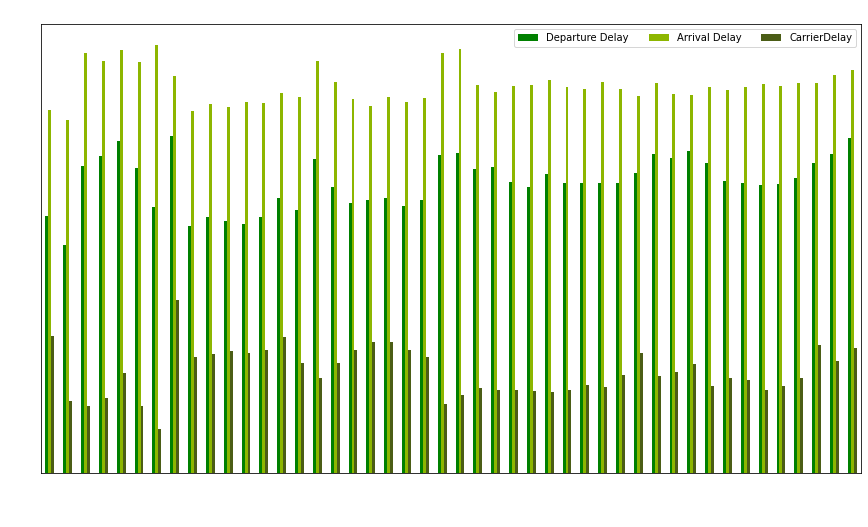

In [47]:
# Plot Average delay of each engine year

colors = ['#008000', '#8DB600','#4B5D16']

# plot
plane_characteristic.groupby('year')[['DepDelay','ArrDelay',"CarrierDelay"]].mean().plot.bar(figsize=[14.70, 8.27], color=colors)
                                                                
# title, lables & legend
plt.title("E) Distribution of Delay over Engine year of the plane", fontsize = 14, weight = "bold", color = "white")
plt.ylabel('Average Delay (min)', fontsize = 10, weight = "bold", color = "white")
plt.xlabel('Engine Year', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.legend(['Departure Delay', 'Arrival Delay',"CarrierDelay"],ncol = 3)
plt.show()

From the graph, we don't see much of fluctuation or difference between each engine year. Hence, we can assume that age of the plane does not have great impact on its delays.

# 3) How does the number of people flying between different locations change over time?

In [48]:
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [49]:
# Merge airport dataset which includes airport details into preprocessed dataset "df_copy".

Destination = df_copy.merge(airports, left_on='Dest', right_on='iata', how='inner')

In [50]:
# Concatenate flights origin and destination to observe its route.

Destination["Trip"] = Destination["Origin"] + "-" + Destination["Dest"]

In [51]:
# Indicate seasons for each flights
# December to February = Winter
# March to May = Spring
# June to August = Summer
# September to November = Autumn

Destination["season"] = ""
Destination["season"] = Destination.Date.dt.month_name()


Destination.loc[Destination['season'] == "December", 'season'] = "Winter"
Destination.loc[Destination['season'] == "January", 'season'] = "Winter"
Destination.loc[Destination['season'] == "February", 'season'] = "Winter"

Destination.loc[Destination['season'] == "March", 'season'] = "Spring"
Destination.loc[Destination['season'] == "April", 'season'] = "Spring"
Destination.loc[Destination['season'] == "May", 'season'] = "Spring"

Destination.loc[Destination['season'] == "June", 'season'] = "Summer"
Destination.loc[Destination['season'] == "July", 'season'] = "Summer"
Destination.loc[Destination['season'] == "August", 'season'] = "Summer"

Destination.loc[Destination['season'] == "September", 'season'] = "Autumn"
Destination.loc[Destination['season'] == "October", 'season'] = "Autumn"
Destination.loc[Destination['season'] == "November", 'season'] = "Autumn"

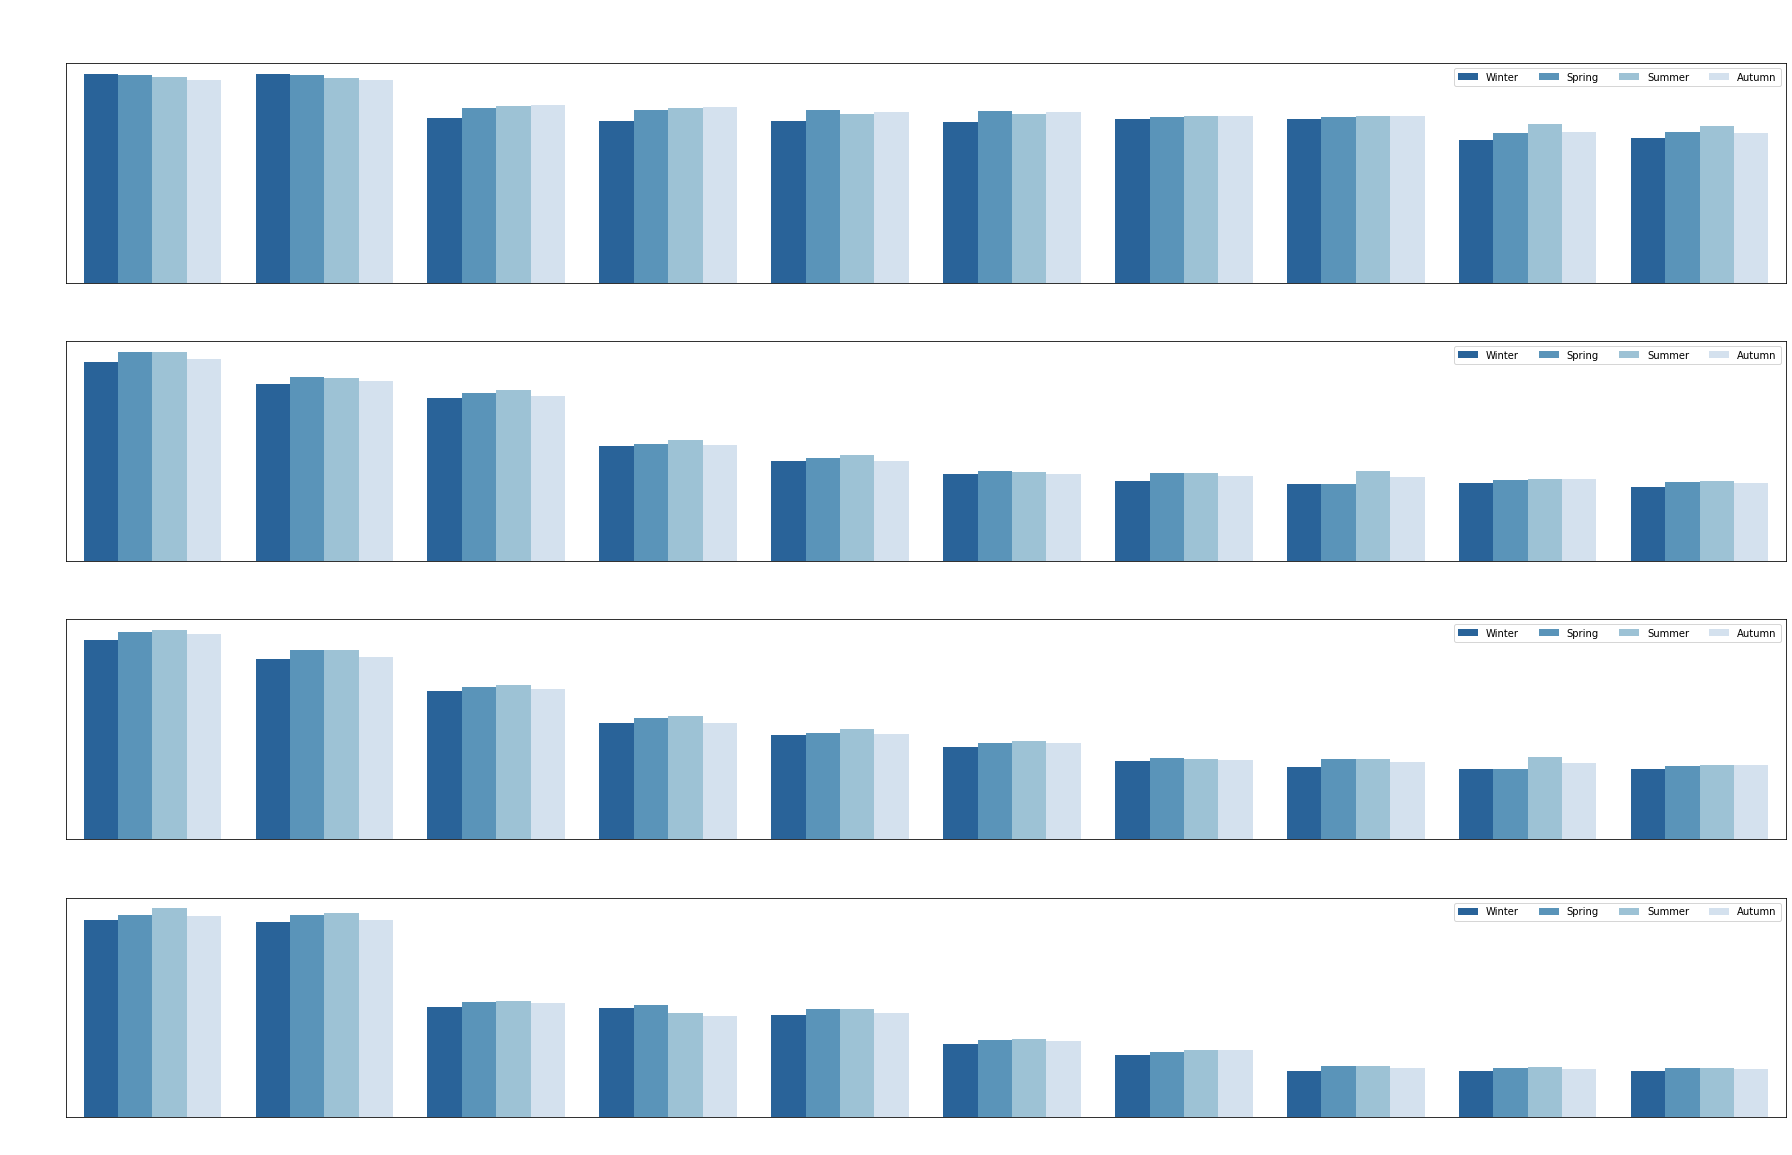

In [52]:
# To identify the number of people flying between different locations over time, plot most visited trips,
# airport, city, and state.

figure, ((ax1, ax2, ax3, ax4)) = plt.subplots(ncols = 1, nrows = 4)
figure.set_size_inches(25,16)

# Main Title
figure.suptitle('F) Most Visited',x=0.52, y=1,fontsize = 18,fontweight ="bold", color = "white")

# Top 10 Most Frequent Trips

# get order
order = Destination["Trip"].value_counts(ascending=False).iloc[:10].index

# barchart
sns.countplot(data=Destination, x='Trip', order=order, palette='Blues_r',ax = ax1, hue = "season")

# axes labels and title

ax1.set_title('1) Top 10 Most Frequent Trips', fontsize = 14, weight = "bold",color = "white")
ax1.set_xlabel('Trip', fontsize = 10, weight = "bold",color = "white")
ax1.set_ylabel('Count', fontsize = 10, weight = "bold",color = "white")
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax1.legend(ncol = 4)
#-----------------------------------------------------------

# Top 10 Most Visited Airport

# get order
order = Destination["airport"].value_counts(ascending=False).iloc[:10].index

# barchart
sns.countplot(data=Destination, x='airport', order=order, palette='Blues_r',ax = ax2, hue = "season")

# axes labels and title
ax2.set_title('2) Top 10 Most Visited Airport', fontsize = 14, weight = "bold",color = "white")
ax2.set_xlabel('Airport', fontsize = 10, weight = "bold",color = "white")
ax2.set_ylabel('Count', fontsize = 10, weight = "bold",color = "white")
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
ax2.legend(ncol = 4)
#---------------------------------------------------------

# Top 10 Most Visited City 

# get order
order = Destination["city"].value_counts(ascending=False).iloc[:10].index

# barchart
sns.countplot(data=Destination, x='city', order=order, palette='Blues_r',ax = ax3, hue = "season")

# axes labels and title

ax3.set_title('3) Top 10 Most Visited City', fontsize = 14, weight = "bold",color = "white")
ax3.set_xlabel('City', fontsize = 10, weight = "bold",color = "white")
ax3.set_ylabel('Count', fontsize = 10, weight = "bold",color = "white")
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')
ax3.legend(ncol = 4)

#---------------------------------------------------------

# Top 10 Most Visited state 

# get order
order = Destination["state"].value_counts(ascending=False).iloc[:10].index

# barchart
sns.countplot(data=Destination, x='state', order=order, palette='Blues_r',ax = ax4, hue = "season")

# axes labels and title

ax4.set_title('4) Top 10 Most Visited state', fontsize = 14, weight = "bold",color = "white")
ax4.set_xlabel('City', fontsize = 10, weight = "bold",color = "white")
ax4.set_ylabel('Count', fontsize = 10, weight = "bold",color = "white")
ax4.tick_params(axis='x', colors='white')
ax4.tick_params(axis='y', colors='white')
ax4.legend(ncol = 4)

figure.tight_layout()

We divided 4 different sections to demonstrate how the number of people fly between different locations change over time. As we can see from the plot, most frequent trip happened in between Los Angeles International Airport (LAX) and San Diego International Airport (SAN) during winter compared to other seasons. This makes sense because temperatures in San Diego are sufficiently warm year-round, hence we can assume that people tend to visit San Diego during winter to get rid of the cold weather and fill the warm air. Similar finding could be applicable for other flight's route too. 
Moreover, we can identify that having the most frequent trip doesn’t necessarily mean it would be parallel to the most visited airport, city and state since numerous airports are correlated with lots of different city and state. Thus, F-2 plot with William B Hartsfield-Atlanta Intl airport as the most visited airport located in the city of Atlanta is contrasting to F-3 plot showing Chicago as the most visited city. 
Furthermore, people tend to travel more on spring and summer when the weather is ideal. For summer, it may be due to summer vacation trips. While for spring, considered as off-season compared to summer, could have fewer crowds and the prices of touring may be less compared to summer when prices soar which would then result to encourage people to travel during spring. Hence month and origin of the airport could be an important indicator for prediction model.

# 4) Can you detect cascading failures as delays in one airport create delays in others?

In [53]:
# We used "Destination" dataset from question 3 which includes the airport details.
# Filter out flights with no "LateAircraftDelay" from "Destination" DF
# since we are trying to detect cascading failures as delays in one airport create delays in others

Airport = Destination[Destination["LateAircraftDelay"] > 0]

In [54]:
# In addition, Filter out flights with no delayed arrival and departure

Airport = Airport[(Airport["DelayedArr"] > 0) & (Airport["DelayedDep"] > 0)]

In [55]:
# Drop variables that will not be used for the readers to ease their reading

remove = [
    'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'ActualElapsedTime',
    'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled',
    'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
    'DelayedArr', 'DelayedDep', "season", "country",
    'lat', 'long'
]

Airport.drop(remove, axis=1, inplace=True)
Airport = Airport[[
    "Date",
    "Trip",
    "DepTime",
    "DepHour",
    'LateAircraftDelay',
    "TailNum",
    'FlightNum',
]]

In [56]:
Airport.head()

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
21160,2003-06-12,DEN-MSY,17:01,17,46.0,N323UA,1156
21177,2003-06-29,DEN-MSY,16:25,16,40.0,N399UA,1156
21201,2003-06-12,IAD-MSY,17:46,17,15.0,N474UA,1199
21211,2003-06-22,IAD-MSY,18:26,18,58.0,N348UA,1199
21220,2003-06-12,ORD-MSY,10:22,10,6.0,N946UA,1207


In [57]:
# We will use Flights with Tail Number "N336" and "N337 which is one of the most flights made to further investigate on the
# cascading failures as delays in one airport create delays in others.

Airport[Airport["TailNum"] == "N336"]

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
22727,2003-06-22,HOU-MSY,22:48,22,23.0,N336,2442
27305,2003-07-18,PHX-MSY,09:05,09,14.0,N336,1812
66308,2004-04-12,TPA-MSY,11:30,11,110.0,N336,2993
66854,2004-04-22,HOU-MSY,19:20,19,18.0,N336,1419
70174,2004-05-02,HOU-MSY,19:30,19,22.0,N336,1419
...,...,...,...,...,...,...,...
18802382,2005-05-12,PHX-LIT,19:40,19,25.0,N336,2035
18803999,2005-06-10,DAL-LIT,12:42,12,16.0,N336,1444
18805794,2005-07-21,STL-LIT,13:15,13,23.0,N336,869
18828261,2004-09-10,HOU-CRP,21:42,21,19.0,N336,55


In [58]:
Airport[Airport["TailNum"] == "N337"]

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
25985,2003-07-31,BHM-MSY,16:12,16,37.0,N337,2238
44256,2003-11-05,HOU-MSY,16:10,16,25.0,N337,810
61892,2004-03-14,HOU-MSY,19:58,19,33.0,N337,1037
62019,2004-03-16,IND-MSY,12:40,12,33.0,N337,2399
71417,2004-05-24,MCO-MSY,20:03,20,38.0,N337,1276
...,...,...,...,...,...,...,...
18800692,2005-04-05,DAL-LIT,19:44,19,39.0,N337,46
18800959,2005-04-25,DAL-LIT,17:44,17,55.0,N337,38
18810594,2005-10-16,PHX-LIT,18:50,18,68.0,N337,2035
18833300,2005-04-25,HOU-CRP,21:47,21,62.0,N337,53


In [59]:
# scrutinize into specific date

Airport[(Airport["TailNum"] == "N336") & (Airport["Date"] == "2004-01-05")]

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
2076030,2004-01-05,SAT-PHX,16:03,16,28.0,N336,1770
4512473,2004-01-05,PHX-LAX,17:45,17,27.0,N336,1770
9177818,2004-01-05,HOU-SAT,14:45,14,30.0,N336,1770
9295894,2004-01-05,MDW-IND,09:25,09,20.0,N336,2399
11071898,2004-01-05,LAX-LAS,18:28,18,24.0,N336,2545
12858796,2004-01-05,LAS-AUS,19:48,19,19.0,N336,2545
18180977,2004-01-05,MSY-HOU,13:18,13,29.0,N336,2399


In [60]:
# sort "DepHour" in ascending order to see the clear timeline

Airport[(Airport["TailNum"] == "N336") & (Airport["Date"] == "2004-04-12") ]

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
66308,2004-04-12,TPA-MSY,11:30,11,110.0,N336,2993
7961761,2004-04-12,LAS-RNO,18:07,18,78.0,N336,2967
8144991,2004-04-12,RNO-PDX,19:35,19,63.0,N336,2967
9452675,2004-04-12,PDX-GEG,21:08,21,58.0,N336,2967
11110414,2004-04-12,ABQ-LAS,17:18,17,82.0,N336,2967
12867972,2004-04-12,HOU-AUS,14:15,14,120.0,N336,2993
14521766,2004-04-12,DAL-ABQ,16:20,16,93.0,N336,390
17986252,2004-04-12,AUS-DAL,15:05,15,105.0,N336,390
18193921,2004-04-12,MSY-HOU,12:45,12,120.0,N336,2993


In [61]:
# we can identify decreasing LateAircraftDelay in some cases.

Airport[(Airport["TailNum"] == "N336") & (Airport["Date"] == "2004-04-12") & (Airport["FlightNum"] == 2967)].sort_values(by = "DepHour", ascending = True)

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
11110414,2004-04-12,ABQ-LAS,17:18,17,82.0,N336,2967
7961761,2004-04-12,LAS-RNO,18:07,18,78.0,N336,2967
8144991,2004-04-12,RNO-PDX,19:35,19,63.0,N336,2967
9452675,2004-04-12,PDX-GEG,21:08,21,58.0,N336,2967


In [62]:
# sort "DepHour" in ascending order to see the clear timeline

Airport[(Airport["TailNum"] == "N337") & (Airport["Date"] == "2005-06-10") ]

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
4835009,2005-06-10,SJC-LAX,21:20,21,42.0,N337,1091
8208155,2005-06-10,SJC-PDX,17:05,17,8.0,N337,936
8451254,2005-06-10,PDX-SJC,19:15,19,37.0,N337,1091


In [63]:
# Also, we can identify increasing LateAircraftDelay in some cases.

Airport[(Airport["TailNum"] == "N337") & (Airport["Date"] == "2005-06-10")].sort_values(by = "DepHour", ascending = True)

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
8208155,2005-06-10,SJC-PDX,17:05,17,8.0,N337,936
8451254,2005-06-10,PDX-SJC,19:15,19,37.0,N337,1091
4835009,2005-06-10,SJC-LAX,21:20,21,42.0,N337,1091


In [64]:
# We can identify increasing LateAircraftDelay in some cases.

Airport[(Airport["TailNum"] == "N5TEAA") & (Airport["Date"] == "2005-12-26")].sort_values(by = "DepHour", ascending = True)

,Date,Trip,DepTime,DepHour,LateAircraftDelay,TailNum,FlightNum
6344553,2005-12-26,HDN-DFW,15:36,15,64.0,N5TEAA,2228
2411014,2005-12-26,DFW-PHX,19:36,19,84.0,N5TEAA,1807


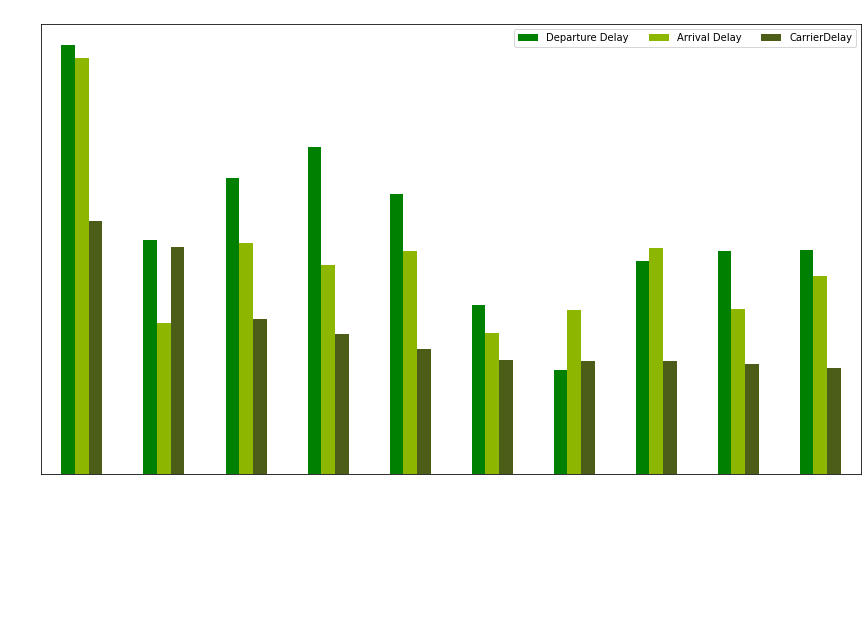

In [65]:
# To further investigate, plot top 10 airports with longest carrier delay as a sample

colors = ['#008000', '#8DB600','#4B5D16']


Destination.groupby('airport')[['DepDelay','ArrDelay',"CarrierDelay"]].mean().sort_values(by = "CarrierDelay",ascending=False)[:10].plot.bar(figsize=[14.70, 8.27], color=colors)
                                                                
# title, lables & legend
plt.title("G) Top 10 airports with longest carrier delay", fontsize = 14, weight = "bold", color = "white")
plt.ylabel('Average Delay (min)', fontsize = 10, weight = "bold", color = "white")
plt.xlabel('Airport', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.legend(['Departure Delay', 'Arrival Delay',"CarrierDelay"],ncol = 3)
plt.show()

From the graph, we can observe fluctuation of average delays for different airports.

In [66]:
# Furthermore, check if different airlines have unusual characteristics on its delays.

Airline = Delayed_flights.merge(carriers, left_on='UniqueCarrier', right_on='Code', how='inner')

In [67]:
# Name each carriers code with its airline.

Airline_names = Airline.set_index('UniqueCarrier')['Description'].to_dict()

In [68]:
Airline_names

{'UA': 'United Air Lines Inc.',
 'US': 'US Airways Inc.',
 'WN': 'Southwest Airlines Co.',
 'MQ': 'American Eagle Airlines Inc.',
 'NW': 'Northwest Airlines Inc.',
 'OO': 'Skywest Airlines Inc.',
 'XE': 'Expressjet Airlines Inc.',
 'TZ': 'ATA Airlines d/b/a ATA',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'FL': 'AirTran Airways Corporation',
 'HP': 'America West Airlines Inc.',
 'AA': 'American Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'B6': 'JetBlue Airways',
 'CO': 'Continental Air Lines Inc.',
 'DH': 'Independence Air',
 'HA': 'Hawaiian Airlines Inc.',
 'OH': 'Comair Inc.',
 'F9': 'Frontier Airlines Inc.'}

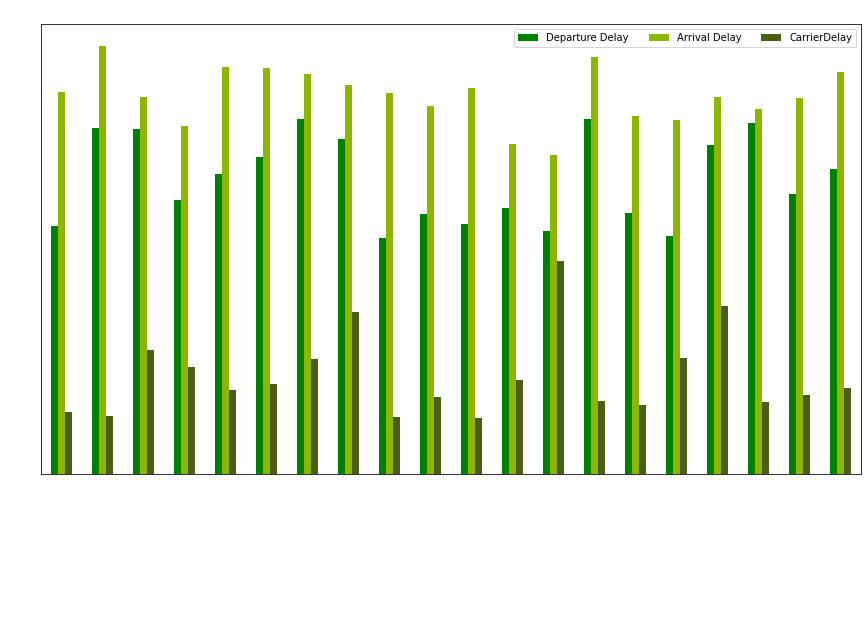

In [69]:
# Plot average delay of each Airline

colors = ['#008000', '#8DB600','#4B5D16']

# plot
Airline.groupby('Description')[['DepDelay','ArrDelay',"CarrierDelay"]].mean().plot.bar(figsize=[14.70, 8.27], color=colors)
                                                                
# title, lables & legend
plt.title("H) Distribution of Delay over Airline", fontsize = 14, weight = "bold", color = "white")
plt.ylabel('Average Delay (min)', fontsize = 10, weight = "bold", color = "white")
plt.xlabel('Airline Code', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.legend(['Departure Delay', 'Arrival Delay',"CarrierDelay"],ncol = 3)
plt.show()

we observed some fluctuation of average delays between different airports and airlines. Hence, we concluded that delays could vary based on their origin of the airports and their airlines

# 5) Use the available variables to construct a model that predicts delays.

In [70]:
# Since the dataset is huge, we will be modeling using 10% of the original dataset.

prediction = df_copy[::10].copy()
prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035626 entries, 0 to 7140590
Data columns (total 35 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int16         
 1   Month              int8          
 2   DayofMonth         int8          
 3   DayOfWeek          int8          
 4   DepTime            object        
 5   CRSDepTime         object        
 6   ArrTime            object        
 7   CRSArrTime         object        
 8   UniqueCarrier      object        
 9   FlightNum          int16         
 10  TailNum            object        
 11  ActualElapsedTime  float32       
 12  CRSElapsedTime     float32       
 13  AirTime            float32       
 14  ArrDelay           float32       
 15  DepDelay           float32       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int16         
 19  TaxiIn             int16         
 20  TaxiOut            int16

In [71]:
# Encode categorical features we will be using into numerical value to allow the model to perform with it.

le = LabelEncoder()
prediction['CRSDepHour'] = le.fit_transform(prediction['CRSDepHour'])
prediction['Origin'] = le.fit_transform(prediction['Origin'])
prediction['UniqueCarrier'] = le.fit_transform(prediction['UniqueCarrier'])

In [72]:
# We can see that the features we converted became numeric.
prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035626 entries, 0 to 7140590
Data columns (total 35 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int16         
 1   Month              int8          
 2   DayofMonth         int8          
 3   DayOfWeek          int8          
 4   DepTime            object        
 5   CRSDepTime         object        
 6   ArrTime            object        
 7   CRSArrTime         object        
 8   UniqueCarrier      int64         
 9   FlightNum          int16         
 10  TailNum            object        
 11  ActualElapsedTime  float32       
 12  CRSElapsedTime     float32       
 13  AirTime            float32       
 14  ArrDelay           float32       
 15  DepDelay           float32       
 16  Origin             int64         
 17  Dest               object        
 18  Distance           int16         
 19  TaxiIn             int16         
 20  TaxiOut            int16

In [73]:
# Since our aim is to predict delayed flights, pick "DelayedArr" as independent variable(label).

label = 'DelayedArr'

# Pick dependent variables(features) that are available in the future flights and assumed to be influencing delays.

features = ['UniqueCarrier','Origin',"CRSDepHour",'Month','Distance']

In [74]:
# Split train and test dataset into half using the "prediction" dataset.
 
train, test = prediction[0::2].reset_index(), prediction[1::2].reset_index()

X_train, y_train = train[features], train[label]
X_test, y_test = test[features], test[label]

In [75]:
# Formula to get accuracy
def accuracy_formula(actual, predict):
    # Getting score of confusion matrix
    cm_data = cm(result['actual'], result['predict'])
    TN, FP, FN, TP = cm_data.ravel()
    # Calculating accuracy
    accuracy = (TP + TN) / len(X_test)
    return accuracy


# Formula to get precision
def precision_formula(actual, predict):
    # Getting score of confusion matrix
    cm_data = cm(result['actual'], result['predict'])
    TN, FP, FN, TP = cm_data.ravel()
    # Calculating precision
    precision = TP / (TP + FP)
    return precision


# Formula to get recall
def recall_formula(actual, predict):
    # Getting score of confusion matrix
    cm_data = cm(result['actual'], result['predict'])
    TN, FP, FN, TP = cm_data.ravel()
    # Calculating recall
    recall = TP / (TP + FN)
    return recall


def F1_Score(actual, predict):
    # Calculating accuracy
    F1 = f1_score(result['actual'], result['predict'])
    return F1


def Evaluation(actual, predict):
    accuracy = accuracy_formula(actual, predict)
    precision = precision_formula(actual, predict)
    recall = recall_formula(actual, predict)
    F1 = F1_Score(actual, predict)

    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, F1))


In [76]:
# We make 3 different predicting models to identify the best model.
# 3 models are logistic regression, random forest and decision tree model.
# We use random_state parameter for reproducibility.
# We use class_weight parameter to balance the class.

m1, m2, m3 = lr(random_state=0, class_weight='balanced'), rf(random_state=0, class_weight='balanced'), dt(random_state=0, class_weight='balanced')

m1.fit(X_train, y_train)
m2.fit(X_train, y_train)
m3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [77]:
# ROC_AUC of logistic regression

predictions = m1.predict(X_test)
pred_proba = m1.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC Score of logistic regression: ', roc_score)

ROC AUC Score of logistic regression:  0.6070706007528054


In [78]:
# ROC_AUC of Random Forest

predictions = m2.predict(X_test)
pred_proba = m2.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC Score of Random Forest: ', roc_score)

ROC AUC Score of Random Forest:  0.6029721068280587


In [79]:
# ROC_AUC of Decision tree

predictions = m3.predict(X_test)
pred_proba = m3.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC Score of Decision tree: ', roc_score)

ROC AUC Score of Decision tree:  0.5795886903872156


Although logistic regression showed the best ROC_AUC score, we will be using Random Forest.

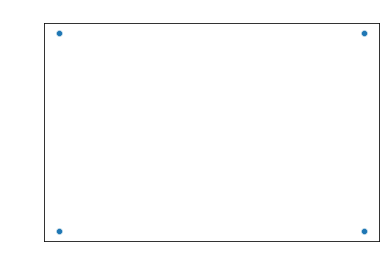

In [80]:
# Made a scatterplot using actual result and predicted result using random forest model.
# Since the values of "DelayedArr" and values to be predicted are 0 and 1, four dots have been plotted.

import seaborn as sns
result = pd.DataFrame()
result['predict'] = m2.predict(X_test)
result['actual'] = y_test
sns.scatterplot(data=result, x='predict', y='actual')

# axes labels and title

plt.title("Actual vs. Predict", fontsize = 14, weight = "bold", color = "white")
plt.xlabel('Predict', fontsize = 10, weight = "bold", color = "white")
plt.ylabel('Actual', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show()

To evaluate the prediction of the model, we will be calculating the following: 
1st, confusion matrix, an evaluation metric for the model, 
2nd, Accuracy, the proportion of the total number of predictions that are correct, 
3rd, precision, the total number of correctly classified positive examples,
4th, recall, the measure of positive examples labeled as positive by classifier, and 
last, F1, the weighted average of Precision and Recall.

In [81]:
# To identify if its well classified, we use evaluation metric called 
# confusion matrix to evaluate the classification.

cm_data = cm(result['actual'], result['predict'])
cm_data

array([[645852, 183523],
       [122852,  65586]])

In [82]:
cm_data.ravel()

array([645852, 183523, 122852,  65586])

In [83]:
TN, FP, FN, TP = cm_data.ravel()

In [84]:
# The proportion of the total number of predictions that are correct.

accuracy = (TP + TN) / len(X_test)
accuracy

0.6989869455391118

In [85]:
# The total number of correctly classified positive examples.

precision = TP / (TP + FP)
precision

0.2632823382535356

In [86]:
# The measure of positive examples labeled as positive by classifier.

recall = TP / (TP + FN)
recall

0.34805081777560787

In [87]:
Evaluation(result['actual'], result['predict'])

accuracy: 0.6990, precision: 0.2633, recall: 0.3481, F1: 0.2998


We will Demonstate how ROC curve is drown.

In [88]:
confidence = m2.predict_proba(X_test)
# .predict_proba method shows information regarding how sure the prediction is.
# Hence if the first row have [0.86898077, 0.13101923], the model predicts the first row of X_test dataset having
# 0 as 86.9% and 1 as 13.1%

confidence
# ROC_Curve is a graph based on this probabilities

array([[0.86898077, 0.13101923],
       [0.86898077, 0.13101923],
       [1.        , 0.        ],
       ...,
       [0.84352256, 0.15647744],
       [0.84813502, 0.15186498],
       [1.        , 0.        ]])

In [89]:
test = pd.DataFrame(confidence, columns=['false', 'positive'])
test['actual'] = y_test
test.head()
# In the case of the first index 0,
# the actual is zero, so it's actually zero.
# Based on the internal judgment criteria of the predictive model, 
# it can be seen that it has a 87% chance of confidence.

,false,positive,actual
0,0.868981,0.131019,0
1,0.868981,0.131019,0
2,1.000000,0.000000,0
3,0.090102,0.909898,1
4,0.090102,0.909898,0


In [90]:
test['predict'] = 0
test.loc[test['positive'] > 0.1, 'predict'] = 1
test.head()

,false,positive,actual,predict
0,0.868981,0.131019,0,1
1,0.868981,0.131019,0,1
2,1.000000,0.000000,0,0
3,0.090102,0.909898,1,1
4,0.090102,0.909898,0,1


In [91]:
test['predict'] = 0
test.loc[test['positive'] > 0.001, 'predict'] = 1
# If it's a good algorithm, we'll get 99.999...% chance of predicting right.
# If it's a bad algorithm, the probability of having right prediction would be close to 50%.
# Therefore, we can draw a confusion matrix by changing the reference point between 0 and 1.
cm_data = cm(test['actual'], test['predict'])
cm_data

array([[183329, 646046],
       [ 24357, 164081]])

In [92]:
all_points = []
for i in range(10):
    test['predict'] = 0
    test.loc[test['positive'] > i * 0.1, 'predict'] = 1
    # As it iterates, it inputs bigger and bigger predicting standard.

    cm_data = cm(test['actual'], test['predict'])
    TN, FP, FN, TP = cm_data.ravel()
    # It makes new confusion matrix for every change of the predicting standard.
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fall_out = FP / (FP + TN)
    # With the new confusion matrix, we calculate the new evaluation metric.
    
    d_point = {'precision' : precision, 
               'recall' : recall, 'fall_out' : fall_out}
    all_points.append(d_point)
    # List the new evaluation metrics into dictionary.
    

In [93]:
roc = pd.DataFrame(all_points)
# We put the stacked evaluation metrics into one dataframe
roc.head()

,precision,recall,fall_out
0,0.202537,0.870743,0.778955
1,0.230999,0.606921,0.459058
2,0.235067,0.548366,0.405433
3,0.236197,0.521461,0.383129
4,0.244483,0.464683,0.326265


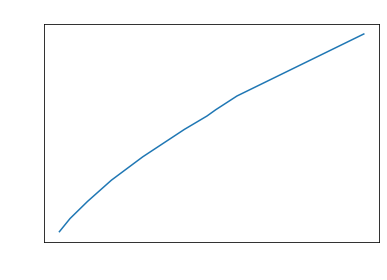

In [94]:
# Now, plot a line graph having X axis as fall-out and Y axis as recall from the dataframe.
# We now have ROC_Curve.

sns.lineplot(data=roc, x='fall_out', y='recall')

# axes labels and title

plt.title("ROC Curve", fontsize = 14, weight = "bold", color = "white")
plt.xlabel('Fall_out', fontsize = 10, weight = "bold", color = "white")
plt.ylabel('Recall', fontsize = 10, weight = "bold", color = "white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

plt.show()

In [95]:
# We will now try hyperparameter tuning.
# What would be the score of the model if we set decision tree as 10, 0.3 of features considered, 
# maximum depth of decision tree as 5 with replacement of sampling and its class weight balanced.

model = rf(n_estimators=10, max_features=0.3, 
           max_depth=5, bootstrap=True,class_weight='balanced')

# A function to score a recall of the model
def scorer(model):
    model.fit(X_train, y_train)
    TN, FP, FN, TP = cm(y_test, model.predict(X_test)).ravel()
    recall = TP / (TP + FN)
    return recall
scorer(model)

0.6536102060094037

In [98]:
# We will now divide each hyperparameter into several cases, 
# put all the combination using for iteration then see the score of prediction model.

n_estimators = [10, 50, 100, 200]
max_features = [0.1, 0.5, 0.9]
max_depth = [3, 5, 7, 9, 12]
bootstrap = [True, False]
# Divide each hyperparameter into several cases
# Put all the combinations into the for statement.
# We will run the predictive model and see the score.
all_score = []
for a in n_estimators:
    for b in max_features:
        for c in max_depth:
            for d in bootstrap:
                model = rf(n_estimators=a, max_features=b, 
                           max_depth=c, bootstrap=d,class_weight='balanced')
                
# a, b, c, and d contain values corresponding to the number of cases of each hyperparameter. 
# Use this to set options and create the model.
               
                recall = scorer(model)
                # Use the scorer function to score a recall.
               
                all_score.append({'a' : a, 'b' : b, 'c' : c, 'd' : d, 'recall' : recall})
                
# Put each hyperparameter value and recall evaluation metrics in 
# dictionary form and put them in the list one by one.
              
pd.DataFrame(all_score).sort_values(by='recall', ascending=False)

,a,b,c,d,recall
11,10,0.5,3,False,0.693231
80,100,0.9,3,True,0.692939
21,10,0.9,3,False,0.692880
111,200,0.9,3,False,0.692642
110,200,0.9,3,True,0.692546
...,...,...,...,...,...
89,100,0.9,12,False,0.619238
28,10,0.9,12,True,0.615592
58,50,0.9,12,True,0.614414
118,200,0.9,12,True,0.613050


grid-search takes quite long time to load, hence random search is often used instead. Although it is done within certain amount of time, it has systematic way to find the appropriate model instead of just putting random values several times. Moreover, it is also called Coarse search because it proceeds two to three times and gradually narrows down.

In [99]:
time_limit = 180
# To make it repeat within certain amount of time,
# Add 180 equivalent to 180 seconds.

t0 = time.time()
# In order to record the time before the start of iteration, 
# record the current time with time.time() in the t0 variable,

all_score = []
# Create a list all_score to collect scores.

while True:
    # use while True for infinite iteration
    
    a = randint(10, 200)
    b = randint(1, 10) / 10
    c = randint(2, len(features))
    d = [True, False][randint(0, 1)]
    # Randomly set the parmeter value of each hyper-parameter.

    model = rf(n_estimators=a, max_features=b, 
               max_depth=c, bootstrap=d,class_weight='balanced')
    # Random forest model with random parameter values used is labeled as model
    
    recall = scorer(model)
    # let scorer function evaluate the model

    all_score.append({'a' : a, 'b' : b, 'c' : c, 'd' : d, 'recall' : recall})
# Create a dictionary indicating what the score was when different 
# hyper-parameter was set and put it into the all_score variable.

    if time.time() - t0 >= time_limit : break
# At this point, use time.time() to see the time difference from t0.
# If it exceeds preset time_limit, use break to terminate the iteration.

result_set = pd.DataFrame(all_score).sort_values(by='recall', ascending=False)
# Create a data frame of recall score in decending order and store it in result_set variable.

In [100]:
coarse_df = result_set.head()
coarse_df
# Top rows show the combination of hyper-parameters with good scores.
# We would like to reflect the range of combinations with good scores
# for each a, b, c, and d in the scope of the next iteration.

# then reset the range of a,b,c,d using the maximum/minimum values of those with 
# good scores among the coarse search results and redo the search

,a,b,c,d,recall
2,189,1.0,5,True,0.672502
1,104,0.4,5,False,0.665466
0,59,0.3,5,True,0.641484


Furthermore, to identify the importance of each variable, we will
be using permutation based feature importance method to identify.

In [103]:
m2.feature_importances_

array([0.07804864, 0.19238505, 0.15441063, 0.1514599 , 0.42369579])

In [106]:
X_train.columns

Index(['UniqueCarrier', 'Origin', 'CRSDepHour', 'Month', 'Distance'], dtype='object')

In [107]:
sorted(zip(m2.feature_importances_,X_train.columns))
# Distance has the biggest influence while unique carrier has the lowest.

[(0.07804864170681919, 'UniqueCarrier'),
 (0.1514598975064387, 'Month'),
 (0.1544106279111403, 'CRSDepHour'),
 (0.19238504698031902, 'Origin'),
 (0.4236957858952829, 'Distance')]